# [DONE|TODO] Separate the static part of the Hamiltonian and the time evolution operator from the time-dependent parts

- done up to the variance of real or imaginary time step
- may be worked for further optimization in near future.

# [LATER|TODO] Animate the analytical result if applicable such as Volkov states

- already done before
- may be done in future for neat implementation in terms of convenient add or removal of additional animation
- thus, registered at github issue.

# [LATER|TODO] Get appropreiate parameter for imaginary potential should be gained through the comparison between imag-pot-present and free one

- compare the imag-pot version and large-enough-grid-size version
- it can be done manually, as it has been already done for some cases.
- thus, pushing it to github issue for later implementation.

# [TODO] Implement file input

- implement class method `self.from_file(filepath)` for convenience

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 15

# Parameter

- may be replaced by input file read

In [2]:
R_in = 50.03
delta_x = 0.2
imag_pot_width = 100.0
delta_t_real = 0.05
t0 = 0.0

## Configure `V_x_func`
from tdse.analytic.potential import get_soft_core_pot_func
V_x_func = get_soft_core_pot_func(q=0.561, a=0.367)

## Configure the pulse
omega = 0.5
num_cycle = 4
E0 = 0.1
phase = np.pi / 2.0
start_time = 0.0

from tdse.analytic.vecpot import get_sin_square_pulse_func
sin_sq_pulse_func = get_sin_square_pulse_func(E0, omega, num_cycle, phase, start_time=start_time)
A_t_func = np.vectorize(sin_sq_pulse_func)

## Configure time
pulse_duration = num_cycle * 2.0 * np.pi / omega
t_max_in = 1.5 * pulse_duration

# Develop Object : `system` etc.

In [3]:
from numbers import Integral, Real
from tdse.tridiag import tridiag_forward, tridiag_backward, get_tridiag_shape
from tdse.integral import normalize_trapezoid, numerical_integral_trapezoidal, eval_norm_trapezoid
from tdse.evol import get_M2_tridiag, get_D2_tridiag, mul_tridiag_and_diag, get_M1_tridiag, get_D1_tridiag


def construct_spatial_array(delta_x, R_in):
    """Construct spatial array"""
    N_x = 2 * int(R_in // delta_x) + 1
    N_x_width = N_x // 2
    R = delta_x * N_x_width
    assert R == (R_in - (R_in % delta_x))  # check consistency
    x_arr = np.linspace(-R, R, N_x)
    assert np.isclose(x_arr[1] - x_arr[0], delta_x, atol=1e-13, rtol=0)  # check consistency
    return x_arr


class System(object): pass

class LinearPolariVelocityGaugeSystem(System):
    
    _imag_prop_diff_thres = 1e-10
    _max_imag_prop_time_steps = 5000
    imag_pot_ampl = 100.0
    
    def __init__(self, 
                 R_in, delta_x, delta_t_real, 
                 t0, imag_pot_width, V_x_func, 
                 A_t_func, t_max_in, sf_arr):
        """
        # Notation
        - `N_x`: the number of spatial grid points
        
        # Arguments
        - `sf_arr`: array of shape (N_x,) or None
            if None: `self.sf_arr` is initialized randomly
        """
        
        ## Check input arguments
        _real_arg_tuple = (R_in, delta_x, delta_t_real, t0, imag_pot_width, omega, t_max_in)
        for _real_arg in _real_arg_tuple: assert isinstance(_real_arg, Real)
        for _callable_arg in (V_x_func, A_t_func): assert callable(_callable_arg)
        assert delta_x > 0 and R_in > delta_x and delta_t_real > 0 and imag_pot_width >= 0
        assert isinstance(sf_arr, np.ndarray) or sf_arr is None
        
        ## Construct spatial array
        self.delta_x = delta_x
        self.N_inner_width = int(R_in // self.delta_x)
        self.N_absorb_width = int(imag_pot_width // self.delta_x)
        self.N_inner_total = 1 + 2 * self.N_inner_width
        self.N_absorb_total = 2 * self.N_absorb_width
        self.N_total_width = self.N_inner_width + self.N_absorb_width
        self.N_total = 1 + 2 * self.N_total_width
        self.R_inner = self.delta_x * self.N_inner_width
        self.R_absorb = self.delta_x * self.N_absorb_width
        self.R_total = self.R_inner + self.R_absorb
        assert np.abs(self.R_total - self.N_total_width * self.delta_x) < 1e-13
        self.x_arr = np.linspace(-self.R_total, self.R_total, self.N_total)
        self.x_inner_arr = self.x_arr[self.N_absorb_width:self.N_total-self.N_absorb_width]
        
        # Aliasing
        self.N_x = self.N_total
        
        # Generate masks for spatial coordinate array
        _inner_x_mask_arr = np.full_like(self.x_arr, False, dtype=bool)
        _inner_x_mask_arr[self.N_absorb_width:self.N_total-self.N_absorb_width] = True
        self.inner_x_mask_arr = _inner_x_mask_arr
        
        ## Construct temporal array
        self.delta_t_real = delta_t_real
        self.t0 = t0
        self.N_timestep = int( (t_max_in - self.t0 + self.delta_t_real) // self.delta_t_real )
        self.t_max = self.t0 + self.delta_t_real * self.N_timestep
        self.N_timepoint = self.N_timestep + 1
        self.t_arr = np.linspace(self.t0, self.t_max, self.N_timepoint)
        assert np.isclose(self.t_arr[1] - self.t_arr[0], self.delta_t_real, atol=1e-14, rtol=0)  # check consistency
        
        ## Assign to members
        self.A_t_func = A_t_func
        self.V_x_func = V_x_func
        
        ## Define some variables
        self._tridiag_shape = get_tridiag_shape(self.N_x)
        
        ## Set the initial state function array
        self.sf_arr = np.empty_like(self.x_arr, dtype=complex)
        if sf_arr is None: self.sf_arr[:] = np.random.rand(self.N_x) - 0.5
        else: self.sf_arr[:] = sf_arr
        assert self.sf_arr is not None
        normalize_trapezoid(self.x_arr, self.sf_arr)
        self.sf_arr_0 = self.sf_arr.copy()
        
        ## Construct the spatial potential array
        self.V_x_arr = np.empty_like(self.x_arr, dtype=complex)
        self.V_x_arr[:] = self.V_x_func(self.x_arr)
        
        # Add imaginary potential for norm absorption
        _absorb_x_mask_arr = ~self.inner_x_mask_arr
        _absorb_x_arr = self.x_arr[_absorb_x_mask_arr]
        self.V_x_arr[_absorb_x_mask_arr] = -1.0j * self.imag_pot_ampl \
            * ((_absorb_x_arr - np.sign(_absorb_x_arr) * self.R_inner) / imag_pot_width)**16
        
        ## Evaluate static parts of matrices
        self._M2 = get_M2_tridiag(self.N_x)
        self._D2 = get_D2_tridiag(self.N_x, self.delta_x)
        self._M1 = get_M1_tridiag(self.N_x)
        self._D1 = get_D1_tridiag(self.N_x, self.delta_x)
        self._M2V = mul_tridiag_and_diag(self._M2, self.V_x_arr, dtype=self.V_x_arr.dtype)
        
        self._M2H0 = -0.5 * self._D2 + self._M2V
        
        ## Allocate memory 
        # for time-evolution operator
        self._UA = np.empty(self._tridiag_shape, dtype=complex)
        self._UA_conj = np.empty(self._tridiag_shape, dtype=complex)
        self._U0_half = np.empty(self._tridiag_shape, dtype=complex)
        self._U0_half_conj = np.empty(self._tridiag_shape, dtype=complex)
        self._U0 = np.empty(self._tridiag_shape, dtype=complex)
        self._U0_conj = np.empty(self._tridiag_shape, dtype=complex)


    def eval_energy_expectation_value(self):
        _H0_sf_arr = np.empty_like(self.sf_arr, dtype=complex)
        _M2H0_sf_arr = np.empty_like(self.sf_arr, dtype=complex)
        tridiag_forward(np.asarray(self._M2H0, dtype=complex), self.sf_arr, _M2H0_sf_arr)
        tridiag_backward(self._M2, _H0_sf_arr, _M2H0_sf_arr)
        _energy_exp_val = numerical_integral_trapezoidal(sys.x_arr, self.sf_arr.conj() * _H0_sf_arr)
        return _energy_exp_val
    
    def initialize_sf_arr(self):
        self.sf_arr[:] = self.sf_arr_0
     
    
    def propagate_field_free(self, num_timestep=None, imag_prop=False):
    
        if num_timestep is None:
            if imag_prop: num_timestep = self._max_imag_prop_time_steps
            else: num_timestep = 1
        
        _delta_t = None
        if imag_prop:
            _delta_t = -1.0j * self.delta_t_real
        else: _delta_t = self.delta_t_real
        assert _delta_t is not None

        ## Construct unitary time evolution operators
        self._U0[:] = self._M2 - 1.0j * _delta_t * 0.5 * self._M2H0
        self._U0_conj[:] = self._M2 + 1.0j * _delta_t * 0.5 * self._M2H0
        
        ## Backup the state function for comparison with adjacent timesteps
        _sf_prev_arr = None
        
        ## Prepare intermediate array
        _sf_arr_mid = np.empty_like(self.x_arr, dtype=complex)
        
        ## Iteration for propagation
        for _t_idx in range(num_timestep):
            
            if imag_prop: _sf_prev_arr = self.sf_arr.copy()
                
            tridiag_forward(self._U0, self.sf_arr, _sf_arr_mid)
            tridiag_backward(self._U0_conj, self.sf_arr, _sf_arr_mid)
            
            if imag_prop: normalize_trapezoid(self.x_arr, self.sf_arr)
            if imag_prop:
                _inner_prod = numerical_integral_trapezoidal(self.x_arr, _sf_prev_arr.conj()*self.sf_arr)
                _inner_diff = 1 - np.square(np.abs(_inner_prod))
                print("[{:03d}] difference between previous and current state function: {:.5e}".format(_t_idx, _inner_diff))
                if _inner_diff < self._imag_prop_diff_thres: break
        
    
    def go_to_ground_state(self):
        self.propagate_field_free(num_timestep=self._max_imag_prop_time_steps, imag_prop=True)

    
    def propagate_field_present(self, start_time_index, num_time_step):
        
        ## Allocation
        _sf_arr_mid = np.empty_like(self.sf_arr, dtype=complex)
        
        ## Construct unitary time evolution operators
        self._U0_half[:] = self._M2 - 1.0j * self.delta_t_real * 0.25 * self._M2H0
        self._U0_half_conj[:] = self._M2 + 1.0j * self.delta_t_real * 0.25 * self._M2H0
        self._U0[:] = self._M2 - 1.0j * self.delta_t_real * 0.5 * self._M2H0
        self._U0_conj[:] = self._M2 + 1.0j * self.delta_t_real * 0.5 * self._M2H0
        
        ## iteration for propagation
        _time_index = start_time_index
        _middle_time = self.t0 + self.delta_t_real * (_time_index + 0.5)
        _A_t = self.A_t_func(_middle_time)
        
        self._UA[:] = self._M1 - self.delta_t_real * 0.5 * _A_t * self._D1
        self._UA_conj[:] = self._M1 + self.delta_t_real * 0.5 * _A_t * self._D1

        tridiag_forward(self._U0_half, self.sf_arr, _sf_arr_mid)
        tridiag_backward(self._U0_half_conj, self.sf_arr, _sf_arr_mid)
        
        tridiag_forward(self._UA, self.sf_arr, _sf_arr_mid)
        tridiag_backward(self._UA_conj, self.sf_arr, _sf_arr_mid)
        
        for _time_index in range(start_time_index+1, start_time_index+num_time_step):
            
            _middle_time = self.t0 + self.delta_t_real * (_time_index + 0.5)
            _A_t = self.A_t_func(_middle_time)
            
            self._UA[:] = self._M1 - self.delta_t_real * 0.5 * _A_t * self._D1
            self._UA_conj[:] = self._M1 + self.delta_t_real * 0.5 * _A_t * self._D1

            tridiag_forward(self._U0, self.sf_arr, _sf_arr_mid)
            tridiag_backward(self._U0_conj, self.sf_arr, _sf_arr_mid)
            
            tridiag_forward(self._UA, self.sf_arr, _sf_arr_mid)
            tridiag_backward(self._UA_conj, self.sf_arr, _sf_arr_mid)
            
        tridiag_forward(self._U0_half, self.sf_arr, _sf_arr_mid)
        tridiag_backward(self._U0_half_conj, self.sf_arr, _sf_arr_mid)

# Construct `System` object

In [4]:
sys = LinearPolariVelocityGaugeSystem(
    R_in, delta_x, delta_t_real, 
    t0, imag_pot_width, V_x_func, 
    A_t_func, t_max_in, sf_arr=None)

# Plot

## plot the state function

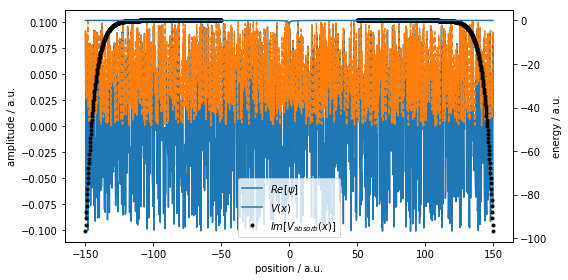

In [5]:
fig_ini, ax_ini = plt.subplots(figsize=(8,4))
l_sf_real, = ax_ini.plot(sys.x_arr, sys.sf_arr.real)
l_sf_abs, = ax_ini.plot(sys.x_arr, np.abs(sys.sf_arr), '--')

ax_energy = ax_ini.twinx()
l_imag_pot, = ax_energy.plot(sys.x_arr[~sys.inner_x_mask_arr], sys.V_x_arr.imag[~sys.inner_x_mask_arr], '.', color='black')
l_pot, = ax_energy.plot(sys.x_arr, sys.V_x_arr.real, '-')

ax_ini.set_xlabel("position / a.u.")
ax_ini.set_ylabel("amplitude / a.u.")
ax_energy.set_ylabel("energy / a.u.")
ax_energy.legend((l_sf_real, l_pot, l_imag_pot),(r'$Re[\psi]$','$V(x)$',"$Im[V_{absorb}{(x)}]$"))

fig_ini.tight_layout()

# fig_ini.savefig("state-func-with-potentials-test-0.png")

## plot $A(t)$ and $E(t)$

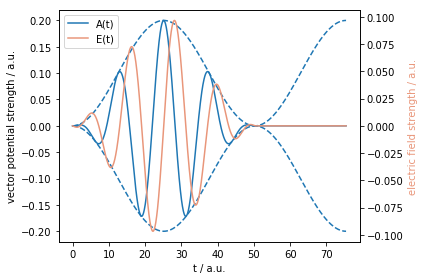

In [6]:
A_t_arr = sys.A_t_func(sys.t_arr)

from tdse.finite_difference import get_first_deriv
E_t_arr = - get_first_deriv(A_t_arr, sys.delta_t_real, zero_boundary=False)
F_t_arr = - E_t_arr

figA, axA = plt.subplots()
A_t_arr = sys.A_t_func(sys.t_arr)
line_A, = axA.plot(sys.t_arr, A_t_arr)
env_arr = E0 / omega * np.square(np.sin(omega / (2*num_cycle) * sys.t_arr))
axA.plot(sys.t_arr, env_arr, sys.t_arr, -env_arr, color=line_A.get_color(), linestyle='--')
axA.set_xlabel("t / a.u."), axA.set_ylabel("vector potential strength / a.u.")

axE = axA.twinx()
line_E, = axE.plot(sys.t_arr, E_t_arr, color='darksalmon')
axE.set_ylabel("electric field strength / a.u.", color=line_E.get_color())

axA.legend((line_A,line_E), ("A(t)", "E(t)"))

figA.tight_layout()

# figA.savefig("At-and-Et-test.png")

# Animate

<IPython.core.display.Javascript object>


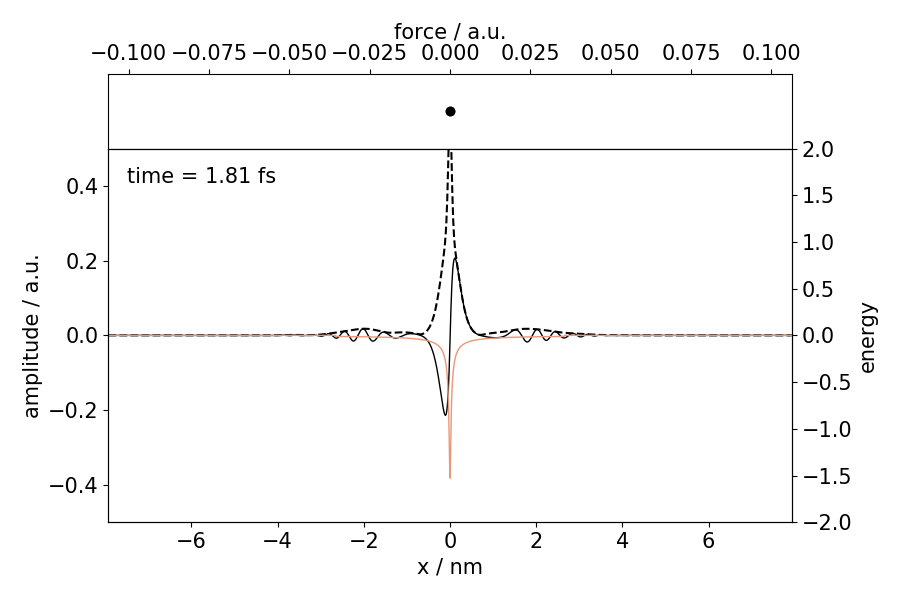

In [7]:
from nunit.au import au2si
au2nm = au2si['length'] * 1e9
au2fs = au2si['time'] * 1e15

%matplotlib notebook

from matplotlib.animation import FuncAnimation

N_off = 10
real_t_index_arr = np.arange(0, sys.N_timepoint, N_off)
imag_t_index_arr = np.arange(0, 0, N_off)
imag_prop_switch_arr = np.hstack((np.full_like(imag_t_index_arr, True, dtype=bool), np.full_like(real_t_index_arr, False, dtype=bool)))
# t_index_arr = np.arange(0, sys.N_timepoint, N_off)
t_index_arr = np.hstack((real_t_index_arr, imag_t_index_arr))
N_frame = t_index_arr.size

figani, (axE, axani) = plt.subplots(2, 1,  gridspec_kw={'height_ratios': [1, 5], 'hspace':0.0}, figsize=(9,6))

axpot = axani.twinx()
line_pot, = axpot.plot([],[], color='darksalmon', linewidth=1.0)
axpot.set_ylim(-2,2)
axpot.set_ylabel("energy")

from vis.layout import get_text_position_and_inner_alignment
pos_xy, pos_kw = get_text_position_and_inner_alignment(axani, 'nw')

line_sf, = axani.plot([],[], linewidth=1.0, color='black')
line_sf_abs, = axani.plot([],[], color=line_sf.get_color(), linestyle='--')
line_E, = axE.plot([],[], color='black', marker='o')
# axE.plot([0],[0], color=line_E.get_color(), marker='.')

F_max = np.abs(F_t_arr).max()
axE.xaxis.set_ticks_position('top')
axE.xaxis.set_label_position('top')
axE.set_xlim(-F_max*1.1,F_max*1.1)
axE.set_xlabel("force / a.u.")
axE.yaxis.set_ticks([])

# axani.set_xlim(sys.x_arr[0],sys.x_arr[-1])
axani.set_xlim(sys.x_arr[0]*au2nm,sys.x_arr[-1]*au2nm)
axani.set_ylim(-0.5, 0.5)
axani.set_xlabel("x / nm"), axani.set_ylabel("amplitude / a.u.")


_x_arr = sys.x_arr * au2nm

fargs = (line_sf, line_sf_abs, t_index_arr, _x_arr)

text_time = axani.text(*pos_xy, "", fontdict=pos_kw)

text = axani.text(0,0.2,"")

figani.tight_layout()

def init_frame():
    sys.sf_arr[:] = sys.sf_arr_0
    sys.go_to_ground_state()
    return (line_sf, line_sf_abs)

def update_frame(frame_index, line_sf, line_sf_abs, t_index_arr, _x_arr):
    try:
        _do_propagate_for_next_frame = frame_index > 0 #frame_index < (t_index_arr.size - 1)
        if _do_propagate_for_next_frame:
            sys.propagate_field_present(t_index_arr[frame_index-1], (t_index_arr[frame_index]-t_index_arr[frame_index-1]))
        
        _t_index = t_index_arr[frame_index]
        
        line_sf.set_data(_x_arr, sys.sf_arr.real)
        line_sf_abs.set_data(_x_arr, np.abs(sys.sf_arr))
        line_E.set_data([0, (~imag_prop_switch_arr[frame_index])*F_t_arr[_t_index]], [0,0])
        line_pot.set_data(_x_arr, sys.V_x_arr + (~imag_prop_switch_arr[frame_index])*E_t_arr[_t_index] * _x_arr)

        _t_au = sys.t_arr[_t_index]
        text_time.set_text("time = {:3.2f} fs".format(_t_au * au2fs))
            
    except Exception as e: text.set_text("ERROR: '{}'".format(e))
        
    return (line_sf, line_sf_abs)

ani = FuncAnimation(figani, update_frame, frames=N_frame, init_func=init_frame, fargs=fargs, repeat=False, blit=True)

In [8]:
# figani.savefig("state-func-R-{:.2f}-with-imag-pot-ampl-{:.2e}-t-max-{:.2f}.png".format(sys.R, sys.imag_pot_ampl, sys.t_max))

from matplotlib.animation import ImageMagickWriter
# ani.save("ani-with-Ft-soft-core-pot.gif", writer=ImageMagickWriter())

# Energy spectrum evaluation with Window Operator Method

In [9]:
winop_n = 3
winop_gamma = 0.01

N_plus = 2000

E_min = -1.5
N_E = 200
E_arr = E_min + 2*winop_gamma*np.arange(N_E)

In [10]:
from tdse.winop.resol import enlarge_x_arr, enlarge_arr

x_arr_winop = enlarge_x_arr(N_plus, sys.x_arr)
sf_arr_winop = enlarge_arr(N_plus, sys.sf_arr)
V_x_arr_winop = enlarge_arr(N_plus, sys.V_x_arr)

In [11]:
from tdse.winop.resol import eval_delta_E

E_max = 1.8
delta_E_max = eval_delta_E(E_max, x_arr_winop)
print("The energy resolution is large enough compared to estimated continuum state density: {}".format(winop_gamma > delta_E_max))
print("window operator gamma: {:.5f} / delta_E: {:.5f}".format(winop_gamma, delta_E_max))

The energy resolution is large enough compared to estimated continuum state density: True
window operator gamma: 0.01000 / delta_E: 0.00542


In [12]:
from tdse.winop import eval_energy_spectrum_for_1D_hamil
spectrum_E_arr = eval_energy_spectrum_for_1D_hamil(sf_arr_winop, x_arr_winop, V_x_arr_winop, E_arr, winop_n, winop_gamma)

<IPython.core.display.Javascript object>


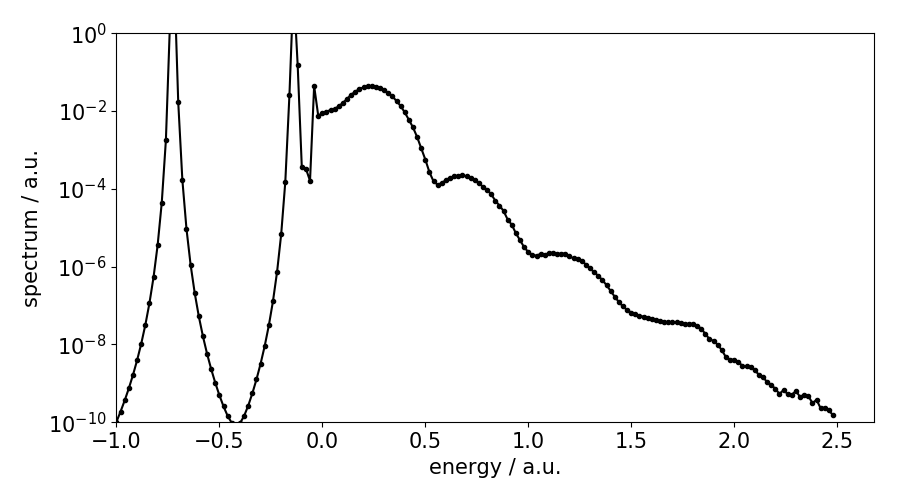

In [13]:
figE, axE = plt.subplots(figsize=(9,5))
axE.semilogy(E_arr, spectrum_E_arr, '.-', color='black')
axE.set_ylabel("spectrum / a.u.")
axE.set_xlabel("energy / a.u.")
axE.set_xlim(-1.0,)
axE.set_ylim(1e-10,1e0)
figE.tight_layout()

In [14]:
fig_file_name = "energy-spectrum-correct-imag-pot-winop-n-{:d}-N-plus-{:d}-gamma-{:.4f}-R-{:.2f}-with-imag-pot-ampl-{:.2e}-t-max-{:.2f}.png".format(
    winop_n, N_plus, winop_gamma, sys.R_inner, sys.imag_pot_ampl, sys.t_max)
print(fig_file_name)
# figE.savefig(fig_file_name)

energy-spectrum-correct-imag-pot-winop-n-3-N-plus-2000-gamma-0.0100-R-50.00-with-imag-pot-ampl-1.00e+02-t-max-75.40.png
